## Code description
This code gets the table containing all ScWs of the INTEGRAL telescope's campaign and selects those with Jupiter in the FOV based on a maximum seperation of 8 degrees between the pointing direction and Jupiter's position. The code also accounts for parallax errors due to the seperation between INTEGRAL and Earth. 

## Begin code

In [1]:
import requests
import astroquery.heasarc
from astroquery.simbad import Simbad
from astropy import coordinates as coord
import astropy.units as u
from astroquery.jplhorizons import Horizons
import pandas as pd
from collections import defaultdict
from astropy.time import Time
from astropy.io import ascii
from astropy.table import vstack
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle, get_body_barycentric, EarthLocation, AltAz, GeocentricTrueEcliptic

Jupiter's monthly positions

In [2]:
epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}

jupiter = Horizons(id='599', location='@0',epochs=epochs) 
eph = jupiter.ephemerides()

ra_values = eph['RA'] # ICRS 
dec_values = eph['DEC'] # ICRS
datetime_values = eph['datetime_jd'] # in JD
print(f"Jupiter's monthly position between {epochs['start']} and {epochs['stop']}: \n")
print(eph[['datetime_str', 'RA', 'DEC']])

monthly_intervals = [] # in MJD
for i in range(len(datetime_values) - 1):  
    start_time = Time(datetime_values[i], format='jd').mjd
    end_time = Time(datetime_values[i + 1], format='jd').mjd
    monthly_intervals.append((start_time, end_time))

Jupiter's monthly position between 2003-01-01 and 2025-01-01: 

   datetime_str       RA      DEC   
       ---           deg      deg   
----------------- --------- --------
2003-Jan-01 00:00 133.13461 18.23402
2003-Feb-01 00:00 135.64353 17.59249
2003-Mar-04 00:00  138.1248 16.92216
2003-Apr-04 00:00 140.57899 16.22478
2003-May-05 00:00 143.00678 15.50206
2003-Jun-05 00:00 145.40891  14.7557
2003-Jul-06 00:00 147.78632 13.98736
2003-Aug-06 00:00    150.14 13.19866
2003-Sep-06 00:00 152.47101 12.39117
2003-Oct-07 00:00 154.78053 11.56645
              ...       ...      ...
2024-Mar-21 00:00  50.60927 17.52697
2024-Apr-21 00:00  53.43087 18.24997
2024-May-22 00:00  56.26678 18.92932
2024-Jun-22 00:00    59.116 19.56331
2024-Jul-23 00:00  61.97734 20.15039
2024-Aug-23 00:00  64.84944 20.68914
2024-Sep-23 00:00  67.73074 21.17832
2024-Oct-24 00:00  70.61942 21.61685
2024-Nov-24 00:00  73.51359 22.00384
2024-Dec-25 00:00  76.41117 22.33857
Length = 260 rows


Get the entire full sky table.
As the table has a built in limit of 100,000 rows, we will query multiple tables corresponding to different sky regions.
Then, we will concatenate them into a single table.

According to the ISDC website, there are 455538 total ScWs.

But here we use the fact that Jupiter followed a specific path on the night sky, so we don't need to query every region.

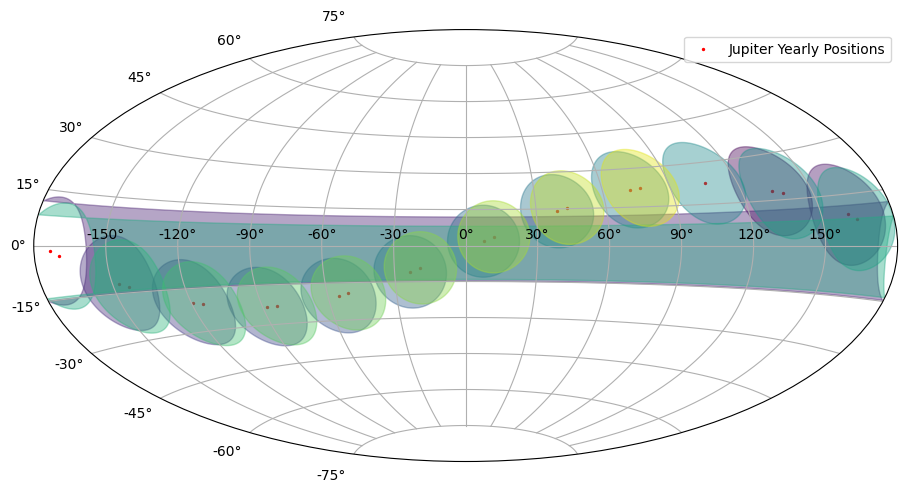

In [4]:
load = True
write = False
plot = True

radius = 15 * u.deg

if load:
    full_table = ascii.read('../data/full_table.dat')
else:
    Heasarc = astroquery.heasarc.Heasarc()

    epochs_yearly = {'start': '2003-01-01', 'stop': '2025-01-01', 'step': '1y'}
    jupiter_yearly = Horizons(id='599', location='@0', epochs=epochs_yearly)
    eph_yearly = jupiter_yearly.ephemerides()

    ra_values_yearly = eph_yearly['RA']
    dec_values_yearly = eph_yearly['DEC']
    jd_times_yearly = eph_yearly['datetime_jd']

    yearly_coords = SkyCoord(ra=ra_values_yearly, dec=dec_values_yearly, unit='deg', frame='icrs')

    tables = []
    for i, coord in enumerate(yearly_coords):
        print(f"  [{i+1}/{len(yearly_coords)}] Querying RA={coord.ra.deg:.2f}, Dec={coord.dec.deg:.2f}")
    
        result = Heasarc.query_region(
            position=coord,
            radius=radius,
            catalog='intscw',
            maxrec=None
        )
        # Check length is < 100,000 (maximum allowed)
        if len(result) == 100000:
            print("Warning: Query returned the maximum allowed of 100,000 rows. Consider reducing the radius.")
            continue
        tables.append(result)

    # Combine all tables
    full_table = vstack(tables, join_type='exact')

    # Remove duplicates (based on scw_id)
    full_table = table.unique(full_table, keys='scw_id')
    print(f"Final table has {len(full_table)} unique rows.")

    if write:
        ascii.write(full_table, '../data/full_table.dat', overwrite=True)
    
if plot:
    Heasarc = astroquery.heasarc.Heasarc()

    epochs_yearly = {'start': '2003-01-01', 'stop': '2025-01-01', 'step': '1y'}
    jupiter_yearly = Horizons(id='599', location='@0', epochs=epochs_yearly)
    eph_yearly = jupiter_yearly.ephemerides()

    ra_values_yearly = eph_yearly['RA']
    dec_values_yearly = eph_yearly['DEC']
    jd_times_yearly = eph_yearly['datetime_jd']

    yearly_coords = SkyCoord(ra=ra_values_yearly, dec=dec_values_yearly, unit='deg', frame='icrs')
    
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': 'aitoff'})
    ax.grid(True)

    ra_rad = yearly_coords.ra.wrap_at(180 * u.deg).radian
    dec_rad = yearly_coords.dec.radian
    ax.scatter(ra_rad, dec_rad, color='red', s=2, label='Jupiter Yearly Positions')

    for i, coord in enumerate(yearly_coords):
        theta = np.linspace(0, 2 * np.pi, 200)
        boundary = coord.directional_offset_by(theta * u.rad, radius)
        ax.fill(boundary.ra.wrap_at(180 * u.deg).radian, boundary.dec.radian, color=plt.cm.viridis(i / len(yearly_coords)), alpha=0.4)

    ax.legend()
    plt.tight_layout()
    plt.show()

Filter for pointing type

In [5]:
pointing_table = full_table[full_table['scw_type'] == 'pointing']
print(f"Pointing table has {len(pointing_table)} unique rows.")

Pointing table has 64378 unique rows.


Filter for good_isgri > 1000

In [6]:
good_isgri_table = pointing_table[pointing_table['good_isgri'] > 1000]
print(f"Good ISGRI table has {len(pointing_table)} unique rows.")

Good ISGRI table has 64378 unique rows.


Build Jupiter table: choose ScWs with pointing seperations less than 8 degrees from Jupiter's position for the corresponding month of each ScW. We also add Jupiter's monthly RA and DEC values.

In [7]:
radius = 8

temp_table = good_isgri_table.copy()
table_coords = SkyCoord(ra=temp_table['ra'], dec=temp_table['dec'], unit='deg') # default is ICRS

mask = np.zeros(len(temp_table), dtype=bool)

jupiter_ra_list = []
jupiter_dec_list = []

for ra, dec, month in zip(ra_values, dec_values, monthly_intervals): # table dates are in MJD
    jupiter_coords = SkyCoord(ra=ra, dec=dec, unit='deg') # default is ICRS
    sep = table_coords.separation(jupiter_coords).deg

    new_mask = (sep <= 8) & (month[0] <= temp_table['start_date']) & (temp_table['start_date'] <= month[1])

    jupiter_ra_list.extend([ra] * np.sum(new_mask))
    jupiter_dec_list.extend([dec] * np.sum(new_mask))

    mask |= new_mask

jupiter_table = temp_table[mask]

jupiter_table['jupiter_ra'] = jupiter_ra_list
jupiter_table['jupiter_dec'] = jupiter_dec_list

print(f"Jupiter table has {len(jupiter_table)} unique rows.")

Jupiter table has 1523 unique rows.


Sort table chronologically

In [8]:
jupiter_table.sort('start_date')

Now, for all of these ScWs, get the exact positions of Jupiter, even accounting for parallax due to the seperation between INTEGRAL and Earth.

In [9]:
def get_integral_position(obs_date):
    url = f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{obs_date}/0/0"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        integral_ra = data['ephs']['ra'] 
        integral_dec = data['ephs']['dec']
        integral_alt = data['ephs']['alt']
        return integral_ra, integral_dec, integral_alt
    else:
        raise ValueError("Error fetching INTEGRAL data")

In [10]:
new_jra = []
new_jdec = []

parallax = True

for i, row in enumerate(jupiter_table):
    obs_date = row['start_date'] # MJD
    jd = Time(obs_date, format='mjd').jd
    obs_date = Time(obs_date, format='mjd').isot

    try:
        eph = Horizons(id='599', location='@0', epochs=jd).ephemerides()
        jra = eph['RA']
        jdec = eph['DEC']
        jalt = eph['delta'] * u.au.to(u.km) * u.km

        if parallax:
            integral_ra, integral_dec, integral_alt = get_integral_position(obs_date)
            
            integral_pos = SkyCoord(ra=integral_ra*u.deg, dec=integral_dec*u.deg, distance=integral_alt*u.km).transform_to('fk5')
            jupiter_pos = SkyCoord(ra=jra, dec=jdec, distance=jalt).transform_to('fk5') 

            delta_vec = jupiter_pos.cartesian - integral_pos.cartesian

            rel_pos = SkyCoord(x=delta_vec.x, y=delta_vec.y, z=delta_vec.z,
                                representation_type='cartesian').transform_to(integral_pos.frame)

            jra = rel_pos.ra.value
            jdec = rel_pos.dec.value

    except Exception as e:
        print(f"[{row['scw']}] Failed to get Jupiter pos: {e}")
        jra = np.nan
        jdec = np.nan

    new_jra.append(jra)
    new_jdec.append(jdec)

jupiter_table['jupiter_ra'] = new_jra # FK5: directly comparable to FITS images (which use FK5)
jupiter_table['jupiter_dec'] = new_jdec

KeyError: 'scw'

Finally, here we will remove the bad ScWs, as per the ISDC website. 

In [180]:
jupiter_table_final = jupiter_table.copy()

# Bad revolutions and SCWs from the INTEGRAL archive
bad_revolutions = {1319, 1320, 1321, 1322, 1323, 1324, 128, 129, 130, 277, 355, 507, 509, 1802, 1803, 1557, 1574}
bad_scws = {"159800130010"}

revolutions = [int(str(scw).zfill(12)[:4]) for scw in jupiter_table_final['scw_id']]
pointings    = [int(str(scw).zfill(12)[4:8]) for scw in jupiter_table_final['scw_id']]

jupiter_table_final['revolution'] = revolutions
jupiter_table_final['pointing'] = pointings

# Here, we filter out the first 5 pointings and last 10 pointings of each revolution
from collections import defaultdict
max_pointing_per_rev = defaultdict(int)
for rev, pt in zip(revolutions, pointings):
    if pt > max_pointing_per_rev[rev]:
        max_pointing_per_rev[rev] = pt

mask = []
for row in jupiter_table_final:
    rev = row['revolution']
    pt  = row['pointing']
    scw = row['scw_id']
    
    if rev in bad_revolutions:
        mask.append(False)
    elif scw in bad_scws:
        mask.append(False)
    elif pt <= 5:
        mask.append(False)
    elif pt >= max_pointing_per_rev[rev] - 10:
        mask.append(False)
    else:
        mask.append(True)

jupiter_table_final = jupiter_table_final[mask]
jupiter_table_final.remove_columns(['revolution', 'pointing'])

print(f"Filtered table has {len(jupiter_table_final)} rows.")

Filtered table has 915 rows.


Save to file

In [181]:
ascii.write(jupiter_table_final, '../data/jupiter_table.dat', overwrite=True)
# jupiter_table = ascii.read('../data/jupiter_table.dat')

Distribution of ScWs

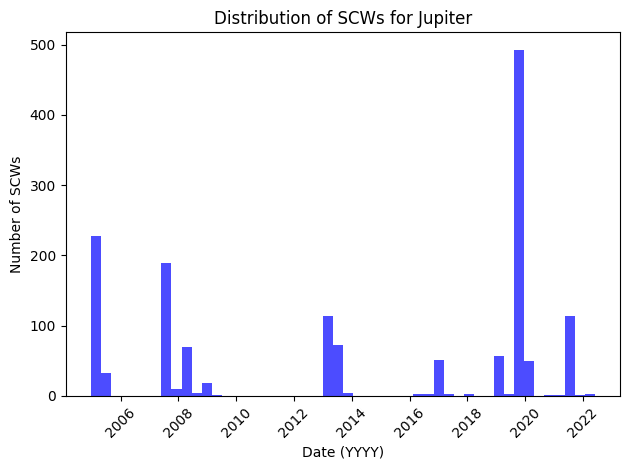

In [182]:
# plot distribution of scws over time

isot_dates = jupiter_table['start_date']
isot_dates = Time(isot_dates, format='mjd').datetime

plt.figure()
plt.hist(isot_dates, bins=50, color='blue', alpha=0.7)
plt.xlabel('Date (YYYY)')
plt.ylabel('Number of SCWs')
plt.title('Distribution of SCWs for Jupiter')
plt.xticks(rotation=45)
plt.tight_layout()